In [1]:
"""
This module provides a class with 6 methods
"""

import os
import pandas as pd
import geopandas as gpd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing


class Group22:
    """
    A class to examine a dataset on agriculture.

    ...

    Attributes
    ----------
    url : str
        url of dataset
    filename : str
        filename of dataset

    Methods
    -------
    download_data:
        downloads two datasets and turns the first one into a pandas dataframe, the second one is a geopandas dataframe
    get_countries:
        creates a list of all countries in the dataframe
    plot_quantity_correlation:
        plots a correlation matrix of quantity columns
    plot_output_area_chart:
        plots an area chart of output columns
    compare_countries_output:
        plots a line graph of output columns for specified countries
    _gapminder_:
        plots agricultural production data for given year
    choropleth:
        plots a choropleth map to visualize agricultural yield data for a given year
    predictor:
        plots the actual and predicted tfp values for up to three specified countries from 1960 to 2050
    """
    def __init__(self, url, filename):

        self.url = url
        self.filename = filename

    def download_data(self):
        """
        Returns agricultural dataframe from the dataset and geodataframe from Natural Earth

        Parameters
        ----------
        None

        Returns
        -------
        dataframes
        """
        if not os.path.exists("../downloads"):
            os.makedirs("../downloads")
            
        if not os.path.exists(os.path.join("../downloads", self.filename)):
            response = requests.get(self.url)
            if response.status_code == 200:
                with open(os.path.join("../downloads", self.filename), "wb") as my_f:
                    my_f.write(response.content)
                print(f"{self.filename} has been downloaded")
            else:
                print(f"Error downloading {self.filename}: {response.status_code}")
        else:
            print(f"{self.filename} already exists")

        data_path = os.path.join("../downloads", self.filename)
        my_df = pd.read_csv(data_path, on_bad_lines="skip")
        
        # Remove aggregated columns
        agg_cols = ['Asia', 'Sahel', 'Central Africa', 'Central America', 'Central Asia','Central Europe', 
                    'Developed Asia', 'Developed countries', 'East Africa', 'Eastern Europe', 'Europe', 
                    'High income', 'Horn of Africa', 'Latin America and the Caribbean', 'Least developed countries', 
                    'Low income', 'Lower-middle income', 'Micronesia', 'North Africa', 'North America', 
                    'Northeast Asia', 'Northern Europe', 'Oceania', 'Pacific', 'South Asia', 
                    'Southeast Asia', 'Southern Africa', 'Southern Europe', 'Sub-Saharan Africa', 
                    'Upper-middle income', 'West Africa', 'West Asia','Western Europe', 'World']
        my_df = my_df[~my_df.Entity.isin(agg_cols)]
        
        # Download and read geographical dataset
        geo_filename = "geo_data"
        if not os.path.exists(os.path.join("../downloads", geo_filename)):
            geo_path = os.path.join("../downloads", geo_filename)
            geo_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        else:
            print(f"{geo_filename} already exists")
            
        self.my_df = my_df
        self.geo_df = geo_df

        return my_df, geo_df

    def get_countries(self):
        """
        Returns a list of unique country names from the
        "Entity" column of the agricultural dataframe.

        Parameters
        ----------
        None

        Returns
        -------
        list of unique country names
        """
        return list(self.my_df["Entity"].unique())

    def plot_quantity_correlation(self):
        """
        Plots a correlation matrix of quantity columns from the
        input dataframe.

        Parameters
        ----------
        None

        Returns
        -------
        None
            Displays a heatmap of the correlation matrix
            of quantity columns.
        """
        quantity_cols = [col for col in self.my_df.columns if "_quantity" in col]
        quantity_df = self.my_df[quantity_cols]
        corr_matrix = quantity_df.corr()
        
        # Create a boolean mask for the upper triangle of the matrix
        mask = np.zeros_like(corr_matrix)
        mask[np.triu_indices_from(mask)] = True

        sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", mask=mask)
        plt.title("Correlation Matrix of Quantity Columns")
        plt.annotate('Source: Agricultural total factor productivity (USDA), OWID 2021', (0,0), (-100,-150), fontsize=10, 
                     xycoords='axes points', textcoords='offset points', va='top')
        plt.show()

    def plot_output_area_chart(self, country=None, normalize=False):
        """
        Plots an area chart of the distinct "_output_" columns.

        Parameters
        ----------
        country : str, optional
            The name of the country to plot the output for.
            If None or 'World', plots the sum for all countries.
            Default is None.
        normalize : bool, optional
            If True, normalizes the output in relative terms:
            each year, output should always be 100%.
            Default is False.

        Raises
        ------
        ValueError
            If no output columns are found in the dataset.
            If the given country name is not valid.
        
        Returns
        -------
        None
        """
        output_cols = [col for col in self.my_df.columns if "_output_" in col]
        if not output_cols:
            raise ValueError("No output columns found in the dataset.")

        if country is None or country == "World":
            df_country = (
                pd.DataFrame(self.my_df)
                .groupby("Year")[output_cols]
                .sum()
                .reset_index()
            )
            title = "World Output"
        else:
            if country not in self.get_countries():
                raise ValueError(f"{country} is not a valid country name.")
            df_country = self.my_df[self.my_df["Entity"] == country][
                ["Year"] + output_cols
            ]
            title = f"{country} Output"

        if normalize:
            df_country[output_cols] = (
                df_country[output_cols].div(df_country[output_cols].sum(axis=1), axis=0)
                * 100
            )

        df_country.set_index("Year").plot(kind="area", stacked=True)
        plt.title(title)
        plt.xlabel("Year")
        plt.ylabel("Output")
        plt.annotate('Source: Agricultural total factor productivity (USDA), OWID 2021', (0,0), (0,-35), fontsize=10, 
                     xycoords='axes points', textcoords='offset points', va='top')
        plt.show()

    def compare_output_countries(self, countries):
        """
        Plots a comparison of the total of the '_output_' column for each of the given countries.

        Parameters:
        ----------
        countries : str or list
            Country or list of countries to compare

        Raises
        ------
        ValueError
            If no output columns are found in the dataset.
            If the provided country/countries is not in the list of valid country names.

        Returns
        -------
        None
        """
        # Create total output column
        output_cols = [col for col in self.my_df.columns if "_output_" in col]
        if not output_cols:
            raise ValueError("No output columns found in the dataset.")
        else:
            self.my_df["total_output"] = pd.DataFrame(self.my_df)[output_cols].sum(axis=1)

        # Transform input to list
        if not isinstance(countries, list):
            countries = countries.split()

        # Plot each given countries output
        for i in countries:
            if i not in self.get_countries():
                raise ValueError(f'{i} is not a valid country name.')
            else:
                country_selected = self.my_df[self.my_df['Entity'].isin([i])][['Entity', 'Year', 'total_output']]
                plt.plot(country_selected['Year'], country_selected['total_output'], label=i)

        plt.title(f'Comparison of Output Totals for selected Countries ({countries})')
        plt.xlabel('Year')
        plt.ylabel('Total Output')
        plt.legend()
        plt.annotate('Source: Agricultural total factor productivity (USDA), OWID 2021', (0,0), (0,-35), fontsize=10, 
                     xycoords='axes points', textcoords='offset points', va='top')
        plt.show()

    def __gapminder__(self, year: int, y_limit = None):
        """
        Plots a scatter plot to visualize agricultural production data for a given year.

        Parameters
        ----------
        year : int
            The year for which to plot the agricultural production data.
        y_limit : int or float, optional
            The upper limit of the y-axis scale. If not given, the y-axis scale will be determined dynamically based on the data.

        Raises
        ----------
        TypeError: If year is not an integer.
        ValueError: If year is not present in the DataFrame.
        ValueError: If y_limit is given but not a positive number.

        Returns
        ----------
        None

        The scatter plot shows the relationship between the quantity of fertilizer
        used and the quantity of agricultural output,
        with the size of each dot indicating the amount of capital invested.
        The x-axis is on a logarithmic scale, and the y-axis scales to a fixed level of billions.
        The data points are labeled with the corresponding country names.
        """
        if not isinstance(year, int):
            raise TypeError("Year must be an integer.")

        if year not in self.my_df["Year"].unique():
            raise ValueError("Year not present in DataFrame.")

        if y_limit is not None and (not isinstance(y_limit, (int, float)) or y_limit <= 0):
            raise ValueError("y_limit must be a positive number.")

        data = self.my_df[self.my_df["Year"] == year]
       
        my_x = data["fertilizer_quantity"].reset_index(drop=True)
        my_y = (data["output_quantity"] / 1e9).reset_index(drop=True) # divide by 1 billion to scale y-axis to billions
        size = (data["capital_quantity"] / 2000).reset_index(drop=True) # set size based on capital_quantity
        country_names = data["Entity"].reset_index(drop=True)
        
        fig, ax = plt.subplots(figsize=(16, 10)) # set figure size to 16 inches by 10 inches
        plt.scatter(my_x, my_y, s=size)
        plt.xscale("log") # set x-axis scale to logarithmic
        plt.xlabel("Fertilizer Quantity (log scale)", fontsize=15)
        plt.xlim(1e0,1e8)
        plt.ylabel("Output Quantity (billions)", fontsize=15)
        plt.title(f"Agricultural Production ({year})", fontsize=15) # remove scientific notation from y-axis tick labels
        plt.tick_params(axis="both", labelsize=15)
        plt.gca().legend(("Capital Quantity (size)",), scatterpoints=1, fontsize=15, loc="upper left")
        plt.annotate('Source: Agricultural total factor productivity (USDA), OWID 2021', (0,0), (0,-40), fontsize=10, 
                     xycoords='axes points', textcoords='offset points', va='top')
        plt.ticklabel_format(axis="y", style="plain") # remove scientific notation from y-axis tick labels
        plt.tick_params(axis="both", labelsize=15)
        
        # set limit of y-axis to the given threshold
        if y_limit is not None:
            plt.ylim(0, y_limit)
            
        # label each data point with the corresponding country name
        avg_output = my_y.mean()
        for i, name in enumerate(country_names):
            plt.annotate(name, (my_x[i], my_y[i]), textcoords="offset points", xytext=(5 + size[i] * 0.01, 5 + size[i] * 0.01),fontsize=int(0.75 * my_y[i] / avg_output))

        plt.show()

    def choropleth(self, year: int):
        """
        Plots a choropleth map to visualize agricultural yield data for a given year.

        Parameters
        ----------
        year : int
            The year for which to plot the agricultural yield data.

        Raises
        ----------
        TypeError: If year is not an integer.
        ValueError: If year is not present in the DataFrame.

        Returns
        ----------
        None
        """
        # Check if the year is an integer
        if not isinstance(year, int):
            raise TypeError('Year must be an integer.')
    
        if year not in self.my_df["Year"].unique():
            raise ValueError('Year not present in DataFrame.')
    
        # Merge the dataframes on the country names
        merge_dict = {'Bosnia and Herzegovina': 'Bosnia and Herz.', 'Burma': 'Myanmar', 'Eswatini': 'eSwatini', 
                      'United States': 'United States of America', 'North Macedonia': 'Macedonia', 
                      'Dominican Republic': 'Dominican Rep.', 'Equatorial Guinea': 'Eq. Guinea', 'South Sudan': 'S. Sudan',
                      'Democratic Republic of Congo': 'Dem. Rep. Congo', 'Solomon Islands': 'Solomon Is.', 'Timor': 'Timor-Leste',
                      'Central African Republic': 'Central African Rep.', 'Macedonia': 'North Macedonia'}
        agr_data = self.my_df.replace({'Entity': merge_dict})
        merged_data = self.geo_df.merge(agr_data, left_on='name', right_on='Entity', how='left')
    
        # Select the data for the specified year
        merged_data_year = merged_data[merged_data.Year == year][['Year', 'geometry', 'tfp', 'pop_est',
                                                                  'continent', 'name', 'iso_a3', 'gdp_md_est']]
        
        # Plot the data on a world map
        fig, ax = plt.subplots(figsize=(20, 15))
        merged_data_year.plot(column='tfp', cmap='YlGnBu', linewidth=1, ax=ax, legend=False)
    
        # Add a title and remove the axis
        ax.set_title(f'Agricultural Yield in {year}', fontdict={'fontsize': '15', 'fontweight': '2'})
        ax.axis('off')
    
        # Add a colorbar
        vmin, vmax = merged_data_year['tfp'].min(), merged_data_year['tfp'].max()
        sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm._A = []
        cbar = fig.colorbar(sm, shrink=0.3)
    
        # Show the plot
        plt.annotate('Source: Natural Earth, 2023', (0,0), (50,0), fontsize=10, 
                     xycoords='axes points', textcoords='offset points', va='top')
        plt.show()
        
    def predictor(self, countries):
        """
        Generates a plot of actual and predicted Total Factor Productivity (TFP) values for up to three specified countries from 1960 to 2050.

        Parameters
        ----------
        countries : list
            A list of country names for which the TFP data should be plotted.

        Raises
        ----------
        ValueError: If all of the specified countries are not present in the dataset. Suggests alternative country options.

        Returns
        ----------
        None
        
        Generates a plot of actual and predicted TFP values for the specified countries.
        """
        
        data = self.my_df
        
        # Limit the number of countries to a maximum of 3
        if len(countries) > 3:
            countries = countries[:3]
            print(f"Only the first three suggested countries {', '.join(countries)} will be taken into account for the prediciton.")

        # Get missing countries and remind user of available countries
        missing_countries = set(countries) - set(data['Entity'])
        if len(missing_countries) == len(countries):
            message = f"The following suggested countries are not present in the dataset: {', '.join(missing_countries)}. You could try these other options: {', '.join(data['Entity'].sample(5))}."
            raise ValueError(message)
        
        # Remove missing countries from the list of countries
        countries = [c for c in countries if c not in missing_countries]
        
        # Iterate over the specified countries and plot their actual TFP data
        fig, ax = plt.subplots()
        
        # Iterate over the specified countries and plot their actual TFP data
        for country in countries:
            country_data = data[data['Entity']==country]
            
            # Compute weights for each year based on its distance from the most recent year
            weights = np.linspace(1, 0.5, len(country_data))
            tfp_data = country_data['tfp'].values
            weighted_tfp = np.average(tfp_data, weights=weights)
            years = country_data['Year'].values
            ax.plot(years, tfp_data, label=country)
            
            # Fit an ETS model to the data and predict future values
            model = ExponentialSmoothing(tfp_data, trend='add')
            model_fit = model.fit()
            future_years = range(max(years)+1, 2051)
            predicted_values = model_fit.predict(start=len(tfp_data), end=len(tfp_data)+len(future_years)-1)
            
            # Plot the predicted values for the country
            ax.plot(future_years, predicted_values, linestyle='--', color=ax.lines[-1].get_color())
        
        ax.legend()
        ax.set_xlabel('Year')
        ax.set_ylabel('TFP')
        ax.set_title('TFP per Year by Country')
        plt.show()

In [2]:
agr_data = Group22('https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/Agricultural%20total%20factor%20productivity%20(USDA)/Agricultural%20total%20factor%20productivity%20(USDA).csv', 'agr_data')
Group22.download_data(agr_data)

agr_data already exists


(            Entity  Year       tfp    output    inputs  ag_land_index  \
 0      Afghanistan  1961   65.0814   44.8285   68.8807        91.6812   
 1      Afghanistan  1962   64.0637   45.6182   71.2075        92.2016   
 2      Afghanistan  1963   61.6217   45.9729   74.6051        92.6352   
 3      Afghanistan  1964   65.1109   49.0775   75.3752        93.1816   
 4      Afghanistan  1965   63.8587   51.2121   80.1960        93.1990   
 ...            ...   ...       ...       ...       ...            ...   
 12177     Zimbabwe  2015  100.0000  100.0000  100.0000       100.0000   
 12178     Zimbabwe  2016   94.8110   98.1051  103.4744       103.8526   
 12179     Zimbabwe  2017  101.9830  104.9815  102.9402        99.6960   
 12180     Zimbabwe  2018  118.1959  121.0832  102.4428       102.8520   
 12181     Zimbabwe  2019  114.9524  114.2108   99.3549        92.5939   
 
        labor_index  capital_index  materials_index  output_quantity  ...  \
 0          44.5145       141.521

In [3]:
Group22.get_countries(agr_data)

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Caribbean',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Czechoslovakia',
 'Democratic Republic of Congo',
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'Former Soviet Union',
 'France',
 'French Guiana',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'Iceland',
 '

Only the first three suggested countries Italy, Afghanistaan, Spain will be taken into account for the prediciton.


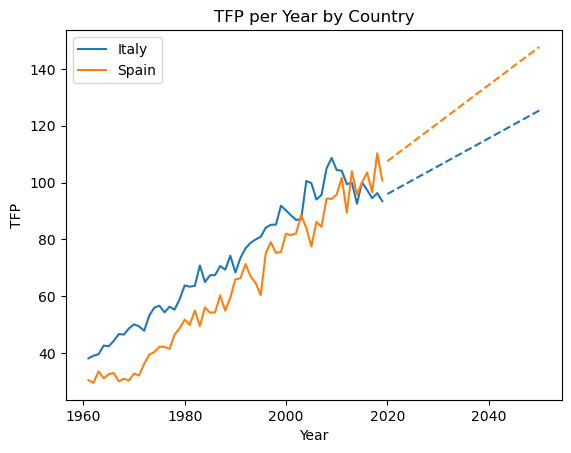

In [4]:
countries = ['Italsfasy','Afghanistan','Spain', 'Gjjermany']
Group22.predictor(agr_data, ['Italy','Afghanistaan','Spain', 'Germany'])

<Axes: >

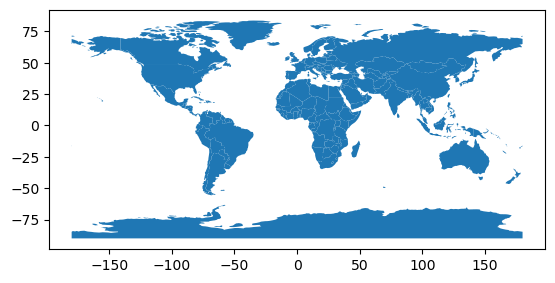

In [5]:
agr_data.geo_df.plot()

/var/folders/1w/kz01_t8d6nqdck_2q7d0g_4h0000gn/T/ipykernel_39295/1965466229.py:371: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, shrink=0.3)


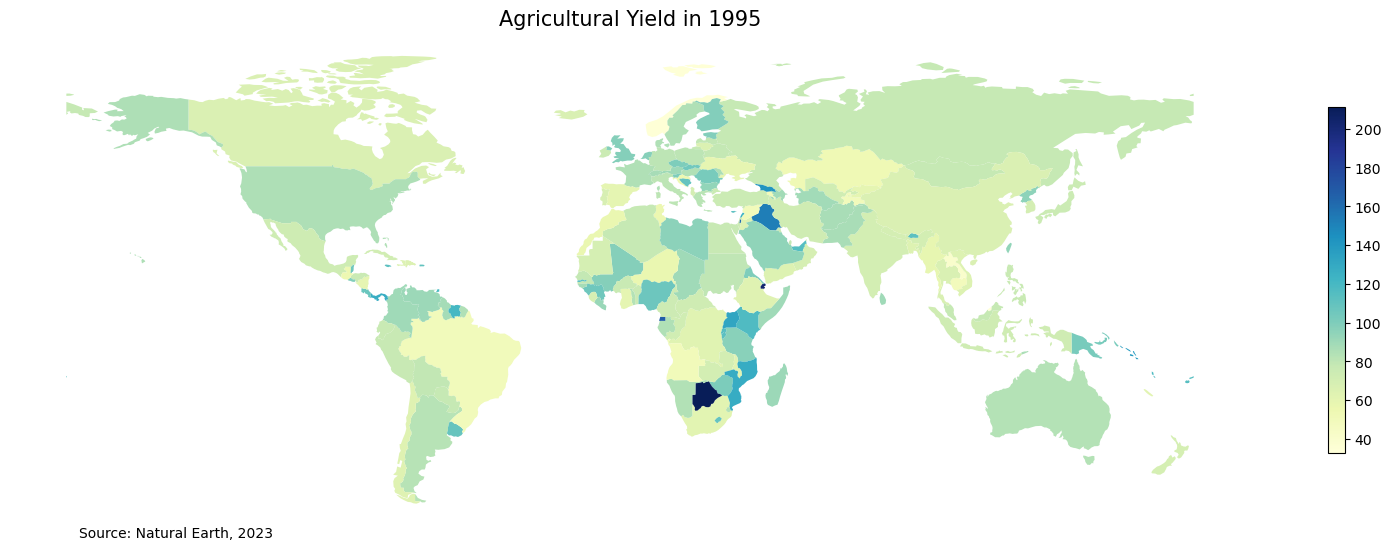

In [6]:
Group22.choropleth(agr_data, 1995)

In [7]:
Group22.get_countries(agr_data)

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Caribbean',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Czechoslovakia',
 'Democratic Republic of Congo',
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'Former Soviet Union',
 'France',
 'French Guiana',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'Iceland',
 '

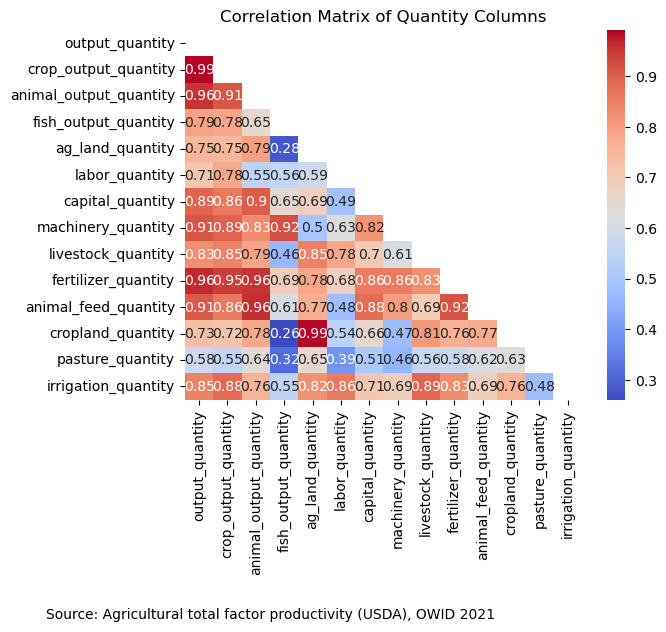

In [8]:
Group22.plot_quantity_correlation(agr_data)

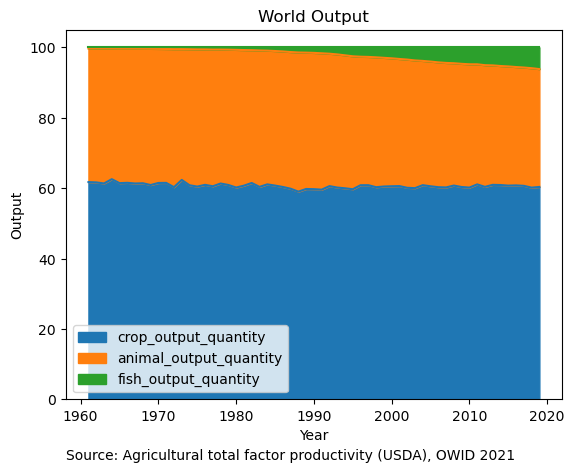

In [9]:
Group22.plot_output_area_chart(agr_data, normalize=True)

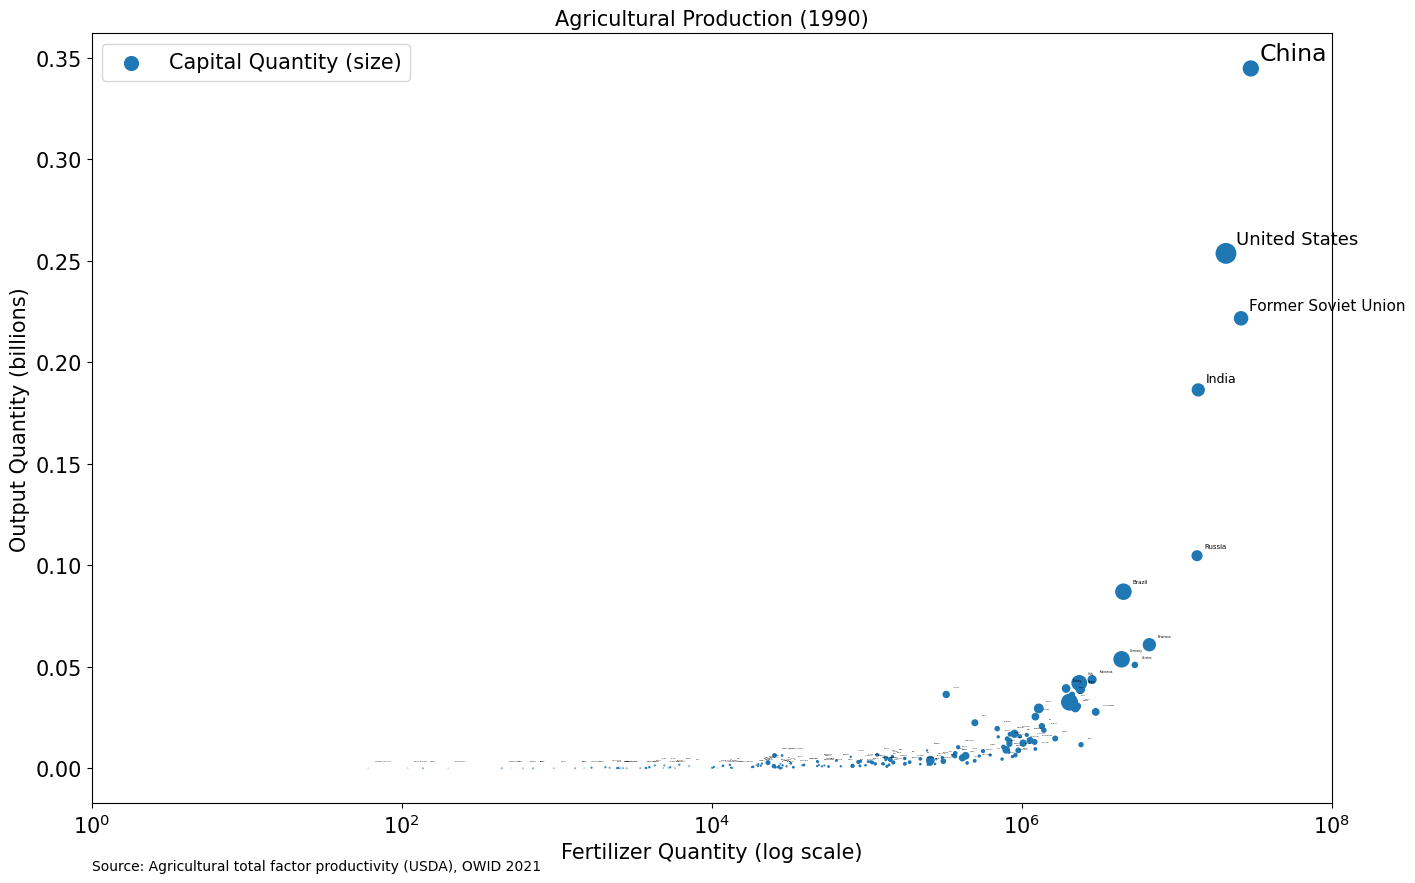

In [10]:
Group22.__gapminder__(agr_data, 1990)

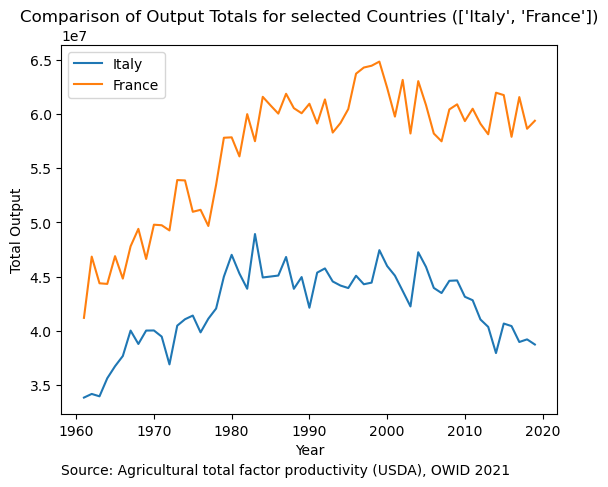

In [11]:
Group22.compare_output_countries(agr_data, ['Italy', 'France'])

In [ ]:
agg_cols = ['Asia', 'Sahel', 'Central Africa', 'Central America', 'Central Asia','Central Europe', 
                    'Developed Asia', 'Developed countries', 'East Africa', 'Eastern Europe', 'Europe', 
                    'High income', 'Horn of Africa', 'Latin America and the Caribbean', 'Least developed countries', 
                    'Low income', 'Lower-middle income', 'Micronesia', 'North Africa', 'North America', 
                    'Northeast Asia', 'Northern Europe', 'Oceania', 'Pacific', 'South Asia', 
                    'Southeast Asia', 'Southern Africa', 'Southern Europe', 'Sub-Saharan Africa', 
                    'Upper-middle income', 'West Africa', 'West Asia','Western Europe', 'World']
my_df = pd.read_csv("https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/Agricultural%20total%20factor%20productivity%20(USDA)/Agricultural%20total%20factor%20productivity%20(USDA).csv", on_bad_lines="skip")
my_df = my_df[~my_df.Entity.isin(agg_cols)]
geo_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


merge_dict = {'Bosnia and Herzegovina': 'Bosnia and Herz.', 'Burma': 'Myanmar', 'Eswatini': 'eSwatini', 
              'United States': 'United States of America', 'North Macedonia': 'Macedonia', 
              'Dominican Republic': 'Dominican Rep.', 'Equatorial Guinea': 'Eq. Guinea', 'South Sudan': 'S. Sudan',
              'Democratic Republic of Congo': 'Dem. Rep. Congo', 'Solomon Islands': 'Solomon Is.', 'Timor': 'Timor-Leste',
              'Central African Republic': 'Central African Rep.', 'Macedonia': 'North Macedonia',}

agr_data = my_df.replace({'Entity': merge_dict})
merged_data = geo_df.merge(agr_data, left_on='name', right_on='Entity', how='left')

In [ ]:
import matplotlib.pyplot as plt


def plot_tfp_arima(countries):
    # Filter the data for the selected countries
    filtered_data = my_df[my_df['Entity'].isin(country_list)]

    # Check if any country is missing
    if len(filtered_data['Entity'].unique()) < len(countries):
        missing_countries = set(countries) - set(filtered_data['Entity'].unique())
        print(f"Warning: the following countries are missing from the dataset and will be ignored: {missing_countries}")
        countries = list(set(countries) - missing_countries)

    if len(countries) > 3:
            countries = countries[:3]
            print(f"Only the first three suggested countries {', '.join(countries)} will be taken into account for the prediciton.")

    # Plot the actual data
    fig, ax = plt.subplots(figsize=(10, 6))
    for country in countries:
        country_data = filtered_data[filtered_data['Entity'] == country]
        ax.plot(country_data['Year'], country_data['tfp'], label=country, linestyle='-')
    
    # Fit an ARIMA model and plot the predictions
    for country in country_list:
        country_data = filtered_data[filtered_data['Entity'] == country]
        model = ARIMA(country_data['tfp'], order=(1, 1, 1))
        fitted_model = model.fit()
        prediction = fitted_model.predict(start=len(country_data), end=2050, typ='levels')
        ax.plot(range(len(countries), 2051), prediction, label=country + " (predicted)", linestyle='--')
    
    # Add labels and legend
    ax.set_xlabel('Year')
    ax.set_ylabel('TFP')
    ax.set_title('TFP and ARIMA predictions for selected countries')
    ax.legend()

    plt.show()

In [ ]:
m = agr_data.Entity.unique()
g = geo_df.name.unique()

s = set(g) - set(m)
s

In [ ]:
w = set(m) - set(g)
w

In [ ]:
countries = ['Italsfasy','Afghanistan','Spain', 'Gjjermany']
Group22.predictor(agr_data, countries)

In [ ]:
def predictor(self, countries):
        """
        Generates a plot of actual and predicted Total Factor Productivity (TFP) values for up to three specified countries 
        from 1960 to 2050.

        Parameters
        ----------
        countries : list
            A list of country names for which the TFP data should be plotted.

        Raises
        ----------
        TypeError: 
        ValueError: If all of the specified countries are not present in the dataset. Suggests alternative country options.

        Returns
        ----------
        None
        
        Generates a plot of actual and predicted TFP values for the specified countries.
        """
        data = self.my_df
        
        
        # Limit the number of countries to a maximum of 3
        if len(countries) > 3:
            countries = countries[:3]
            print(f"Only the first three suggested countries {', '.join(countries)} will be taken into account for the prediciton.")

        # Get missing countries and remind user of available countries
        missing_countries = set(countries) - set(data['Entity'])
        if len(missing_countries) == len(countries):
            message = f"The following suggested countries are not present in the dataset: {', '.join(missing_countries)}. You could try these other options: {', '.join(data['Entity'].sample(5))}."
            raise ValueError(message)
        
        # Remove missing countries from the list of countries
        countries = [c for c in countries if c not in missing_countries]
        
        # Iterate over the specified countries and plot their actual TFP data
        fig, ax = plt.subplots()
        
        # Iterate over the specified countries and plot their actual TFP data
        for country in countries:
            country_data = data[data['Entity']==country]
            
            # Compute weights for each year based on its distance from the most recent year
            weights = np.linspace(1, 0.5, len(country_data))
            tfp_data = country_data['tfp'].values
            weighted_tfp = np.average(tfp_data, weights=weights)
            years = country_data['Year'].values
            ax.plot(years, tfp_data, label=country)
            
            # Fit an ETS model to the data and predict future values
            model = ExponentialSmoothing(tfp_data, trend='add')
            model_fit = model.fit()
            future_years = range(max(years)+1, 2051)
            predicted_values = model_fit.predict(start=len(tfp_data), end=len(tfp_data)+len(future_years)-1)
            
            # Plot the predicted values for the country
            ax.plot(future_years, predicted_values, linestyle='--', color=ax.lines[-1].get_color())
        
        ax.legend()
        ax.set_xlabel('Year')
        ax.set_ylabel('TFP')
        ax.set_title('TFP per Year by Country')
        plt.annotate('Source: Natural Earth, 2023', (0,0), (50,0), fontsize=10, 
                     xycoords='axes points', textcoords='offset points', va='top')
        plt.show()
